In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve


In [45]:
def plot_ROC_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
def plot_PR_curve(recall, precision):
    plt.plot(recall, precision, color='blue', label='PR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [287]:
def plot_pr_curve(y,ytest_prob):
    precision, recall, thresholds = metrics.precision_recall_curve(y, ytest_prob)
    plot_PR_curve(recall,precision)
    f1score = 2*precision*recall/(precision+recall)
    index = np.argmax(f1score)
    optimal_threshold= thresholds[index]
    print('The optimal threshold is', optimal_threshold)
    print('The optimal f1score is', f1score[index])
    return optimal_threshold,f1score[index],recall[index],precision[index]
def plot_roc_curve(y,ytest_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y, ytest_prob)
    plot_ROC_curve(fpr,tpr)
    auc = roc_auc_score(y,ytest_prob)
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    optimal_threshold= thresholds[index]
    print('Area under the curve is', auc)
    print('The optimal threshold is', optimal_threshold)
    
def optimal_confusion_matrix(y,ytest_prob,optimal_threshold):
    ytemp=(ytest_prob > optimal_threshold).astype(int)
    mat= confusion_matrix(y,ytemp) 
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    accuracy=accuracy_score(y,ytemp)
    print('The optimal accuracy is ' ,accuracy)
sns.set_context('poster')

In [2]:
allshots=pd.read_csv('allShots.csv')

In [16]:
model_input = allshots[['x_coordinates','y_coordinates','angles','counter','preferrence','distance','headers']]
model_output = np.ravel(allshots[['goal']])

In [15]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(model_input, model_output, random_state=0,
train_size=0.8)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_1=make_pipeline(LogisticRegression())

In [51]:
grid_values = [{'logisticregression__C': [0.001,0.01,0.1,1,3,5,7,10,100]}]

In [52]:
grid_1 = GridSearchCV(pipe, param_grid = grid_values,scoring = 'f1',verbose=3, cv=5)

In [53]:
grid_1.fit(X1,y1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... logisticregression__C=0.001, score=0.139, total=   0.5s
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ......... logisticregression__C=0.001, score=0.127, total=   0.4s
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ......... logisticregression__C=0.001, score=0.138, total=   0.4s
[CV] logisticregression__C=0.001 .....................................
[CV] ......... logisticregression__C=0.001, score=0.137, total=   0.3s
[CV] logisticregression__C=0.001 .....................................
[CV] ......... logisticregression__C=0.001, score=0.129, total=   0.4s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.147, total=   0.6s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.163, total=   0.5s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.177, total=   0.6s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.172, total=   0.6s
[CV] logisticregression__C=0.01 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   24.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression())]),
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 3, 5,
                                                    7, 10, 100]}],
             scoring='f1', verbose=3)

In [54]:
grid_1.best_score_

0.181408159787053

In [55]:
grid_1.best_params_

{'logisticregression__C': 1}

In [56]:
ytest_labels1=grid_1.predict(X2)
ytest_prob1=grid_1.predict_proba(X2)[:,1]

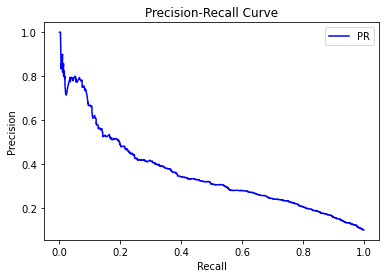

The optimal threshold is 0.1590612706784886
The optimal f1score is 0.3904448105436573


In [143]:
threshold1,f1score1,recall1,precision1=plot_pr_curve(y2,ytest_prob1)
threshold1=np.around(threshold1,4)
f1score1=np.around(f1score1,4)
recall1=np.around(recall1,4)
precision1=np.around(precision1,4)

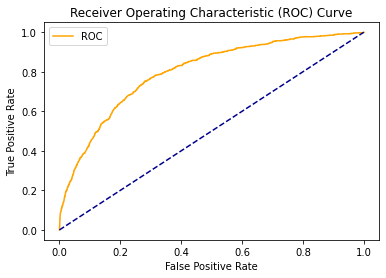

Area under the curve is 0.7981069349988964
The optimal threshold is 0.10678553444231897


In [58]:
plot_roc_curve(y2,ytest_prob1)

In [154]:
log_loss1=log_loss(y2, ytest_prob1, eps=1e-15)
log_loss1=np.around(log_loss1,4)

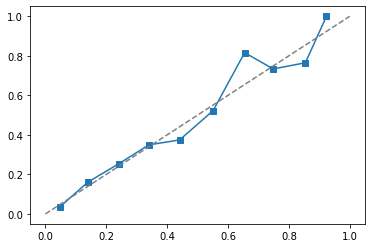

In [63]:
fraction_of_positives1, mean_predicted_values1 = calibration_curve(y2, ytest_prob1, n_bins=10)
plt.plot(mean_predicted_values1, fraction_of_positives1, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
pipe_2 = make_pipeline(RandomForestClassifier())
grid_values_2 = [{'randomforestclassifier__n_estimators': [100,200,300], 'randomforestclassifier__max_depth':[4,6,8,10]}]
grid_2 = GridSearchCV(pipe_2, param_grid = grid_values_2,scoring = 'f1',verbose=3, cv=5)

In [66]:
grid_2.fit(X1,y1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100, score=0.168, total=   0.8s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100, score=0.150, total=   0.8s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100, score=0.161, total=   0.8s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100, score=0.166, total=   0.8s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=100, score=0.157, total=   0.8s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=200 
[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=200, score=0.158, total=   1.6s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=200 
[CV]  randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=200, score=0.141, total=   1.7s
[CV] randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=200 
[CV]  randomforestcl

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid=[{'randomforestclassifier__max_depth': [4, 6, 8, 10],
                          'randomforestclassifier__n_estimators': [100, 200,
                                                                   300]}],
             scoring='f1', verbose=3)

In [67]:
grid_2.best_score_

0.1830069768354702

In [68]:
grid_2.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 200}

In [69]:
ytest_labels2=grid_2.predict(X2)
ytest_prob2=grid_2.predict_proba(X2)[:,1]

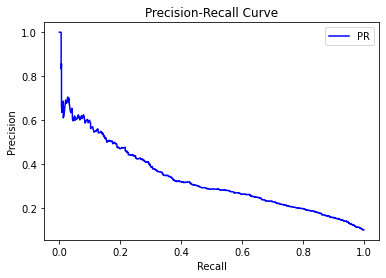

The optimal threshold is 0.1610616843773085
The optimal f1score is 0.3735078937235271


In [144]:
threshold2,f1score2,recall2,precision2=plot_pr_curve(y2,ytest_prob2)
threshold2=np.around(threshold2,4)
f1score2=np.around(f1score2,4)
recall2=np.around(recall2,4)
precision2=np.around(precision2,4)


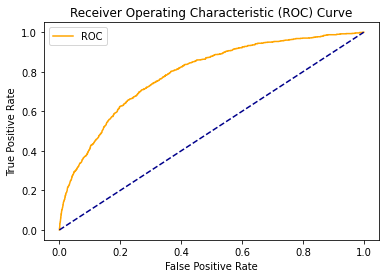

Area under the curve is 0.7880280077867048
The optimal threshold is 0.11781567817972727


In [72]:
plot_roc_curve(y2,ytest_prob2)

In [153]:
log_loss2=log_loss(y2, ytest_prob2, eps=1e-15)
log_loss2=np.around(log_loss2,4)

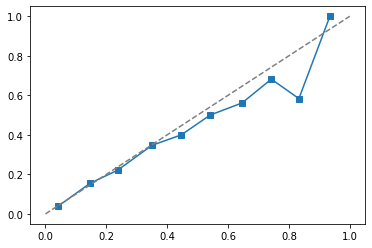

In [74]:
fraction_of_positives2, mean_predicted_values2 = calibration_curve(y2, ytest_prob2, n_bins=10)
plt.plot(mean_predicted_values2, fraction_of_positives2, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

In [75]:
from sklearn.ensemble import AdaBoostClassifier

In [79]:
pipe_3=make_pipeline(AdaBoostClassifier())
grid_values_3 = [{'adaboostclassifier__n_estimators': [100,200,300], 'adaboostclassifier__learning_rate':np.arange(0.1,1.0,0.1)}]

In [80]:
grid_3 = GridSearchCV(pipe_3, param_grid = grid_values_3,scoring = 'f1',verbose=3, cv=5)

In [81]:
grid_3.fit(X1,y1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100, score=0.139, total=   1.3s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100, score=0.148, total=   1.4s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100, score=0.162, total=   1.4s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100 
[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100, score=0.156, total=   1.3s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100 
[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=100, score=0.137, total=   1.3s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=200 
[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=200, score=0.151, total=   2.5s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=200 
[CV]  adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=200, score=0.163, total=   2.6s
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=200 
[CV]  adaboostclassifier__learning_rate=

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  5.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('adaboostclassifier',
                                        AdaBoostClassifier())]),
             param_grid=[{'adaboostclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'adaboostclassifier__n_estimators': [100, 200, 300]}],
             scoring='f1', verbose=3)

In [82]:
grid_3.best_params_

{'adaboostclassifier__learning_rate': 0.6,
 'adaboostclassifier__n_estimators': 100}

In [84]:
grid_3.best_score_

0.19482542809832332

In [86]:
ytest_labels3=grid_3.predict(X2)
ytest_prob3=grid_3.predict_proba(X2)[:,1]

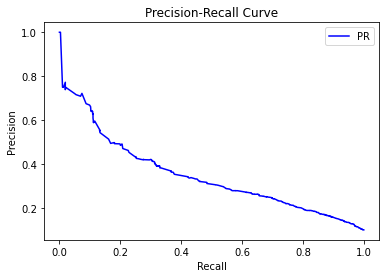

The optimal threshold is 0.4932159945800873
The optimal f1score is 0.3847123057538849


(0.4932159945800873,
 0.3847123057538849,
 0.5210466439135382,
 0.30492676431424764)

In [163]:
plot_pr_curve(y2,ytest_prob3)


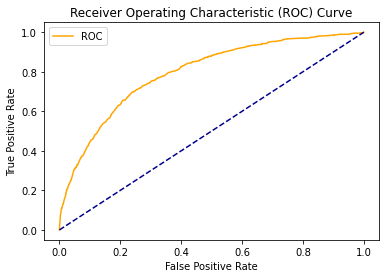

Area under the curve is 0.794236741641416
The optimal threshold is 0.4918627360618871


In [88]:
plot_roc_curve(y2,ytest_prob3)

In [152]:
log_loss(y2, ytest_prob3, eps=1e-15)

0.674270479158631

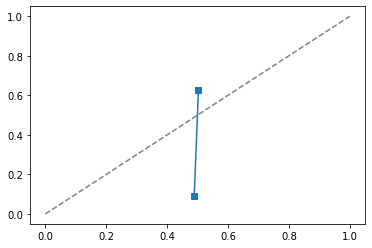

In [90]:
fraction_of_positives3, mean_predicted_values3 = calibration_curve(y2, ytest_prob3, n_bins=10)
plt.plot(mean_predicted_values3, fraction_of_positives3, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

In [91]:
from sklearn.calibration import CalibratedClassifierCV

In [92]:
calibration = CalibratedClassifierCV(base_estimator = grid_3 , cv='prefit')

In [93]:
calibration.fit(X2,y2)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=Pipeline(steps=[('adaboostclassifier',
                                                                              AdaBoostClassifier())]),
                                                   param_grid=[{'adaboostclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                                                'adaboostclassifier__n_estimators': [100,
                                                                                                     200,
                                                                                                     300]}],
                                                   scoring='f1', verbose=3),
                       cv='prefit')

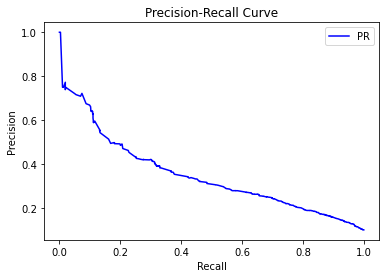

The optimal threshold is 0.1623565244014897
The optimal f1score is 0.3847123057538849


In [164]:
ytest_prob3C=calibration.predict_proba(X2)[:,1]
threshold3,f1score3,recall3,precision3=plot_pr_curve(y2,ytest_prob3C)
threshold3=np.around(threshold3,4)
f1score3=np.around(f1score3,4)
recall3=np.around(recall3,4)
precision3=np.around(precision3,4)

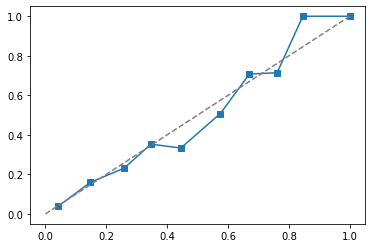

In [95]:
fraction_of_positives3C, mean_predicted_values3C = calibration_curve(y2, ytest_prob3C, n_bins=10)
plt.plot(mean_predicted_values3C, fraction_of_positives3C, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

In [151]:
log_loss3=log_loss(y2, ytest_prob3C, eps=1e-15)
log_loss3=np.around(log_loss3,4)

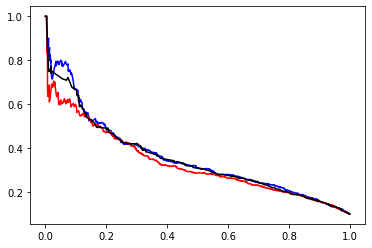

In [127]:
precision1, recall1, thresholds1 = metrics.precision_recall_curve(y2, ytest_prob1)
precision2, recall2, thresholds2 = metrics.precision_recall_curve(y2, ytest_prob2)
precision3, recall3, thresholds3 = metrics.precision_recall_curve(y2, ytest_prob3)
plt.plot(recall1, precision1, color='blue')
plt.plot(recall2, precision2, color='red')
plt.plot(recall3, precision3, color='black')



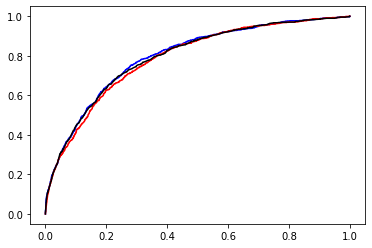

In [129]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y2, ytest_prob1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2, ytest_prob2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y2, ytest_prob3)
plt.plot(fpr1, tpr1, color='blue')
plt.plot(fpr2, tpr2, color='red')
plt.plot(fpr3, tpr3, color='black')


In [130]:
from tabulate import tabulate

In [165]:
table = [['Model','Threshold','F1score','Precision','Recall','Log_loss'],['Logistic Regression',threshold1,f1score1,precision1,recall1,log_loss1],['Random Forest',threshold2,f1score2,precision2,recall2,log_loss2],['AdaBOOST',threshold3,f1score3,precision3,recall3,log_loss3]]

In [166]:
table

[['Model', 'Threshold', 'F1score', 'Precision', 'Recall', 'Log_loss'],
 ['Logistic Regression', 0.1591, 0.3904, 0.306, 0.5392, 0.2739],
 ['Random Forest', 0.1611, 0.3735, 0.2823, 0.5518, 0.2762],
 ['AdaBOOST', 0.1624, 0.3847, 0.3049, 0.521, 0.2741]]

In [167]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════╤═════════════╤═══════════╤═════════════╤══════════╤════════════╕
│ Model               │   Threshold │   F1score │   Precision │   Recall │   Log_loss │
╞═════════════════════╪═════════════╪═══════════╪═════════════╪══════════╪════════════╡
│ Logistic Regression │      0.1591 │    0.3904 │      0.306  │   0.5392 │     0.2739 │
├─────────────────────┼─────────────┼───────────┼─────────────┼──────────┼────────────┤
│ Random Forest       │      0.1611 │    0.3735 │      0.2823 │   0.5518 │     0.2762 │
├─────────────────────┼─────────────┼───────────┼─────────────┼──────────┼────────────┤
│ AdaBOOST            │      0.1624 │    0.3847 │      0.3049 │   0.521  │     0.2741 │
╘═════════════════════╧═════════════╧═══════════╧═════════════╧══════════╧════════════╛


In [170]:
xG=grid_1.predict_proba(model_input)[:,1]

In [172]:
xG=np.around(xG,4)

In [174]:
allshots['xG']=xG

In [175]:
allshots.to_csv('allshots.csv',index=False)

In [176]:
allshots

,playerId,id,x_coordinates,y_coordinates,blocked,goal,time,matchPeriod,counter,competition,foot,bodypart,preferrence,angles,distance,headers,xG
0,25413,177959212,92.40,27.88,0.0,1.0,2.0,0,0.0,0,1.0,1.0,1.0,26.77,14.01,0.0,0.1393
1,26150,177959247,89.25,35.36,0.0,0.0,3.0,0,0.0,0,0.0,2.0,1.0,25.99,15.81,0.0,0.1151
2,14763,177959280,100.80,35.36,0.0,1.0,4.0,0,0.0,0,1.0,3.0,1.0,78.79,4.41,1.0,0.4062
3,7868,177959289,85.05,22.44,0.0,0.0,7.0,0,0.0,0,1.0,2.0,0.0,15.74,23.06,0.0,0.0374
4,7868,177959429,78.75,20.40,0.0,0.0,14.0,0,0.0,0,1.0,1.0,1.0,12.59,29.56,0.0,0.0198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43073,25575,90588469,81.90,41.48,1.0,0.0,85.0,1,0.0,6,1.0,2.0,0.0,16.36,24.28,0.0,0.0328
43074,25575,90588583,97.65,28.56,0.0,0.0,91.0,1,0.0,6,1.0,1.0,1.0,37.46,9.14,0.0,0.2671
43075,70410,90589205,94.50,25.84,0.0,0.0,13.0,2,0.0,6,1.0,3.0,1.0,25.19,13.30,1.0,0.0580
43076,70410,90589254,80.85,31.28,0.0,1.0,3.0,3,0.0,6,1.0,1.0,1.0,17.03,24.30,0.0,0.0392


In [272]:
y=[]
l=np.arange(0,68,2)
x=np.arange(50,106,2)
k=len(x)
for i in range(69):
    for j in range(k):
        y=np.append(y,i)

x=np.vstack([x]*69)
x=np.ravel(x)
        
    
    
    

In [273]:
heatmap_data = pd.DataFrame(x ,columns=['x'])
heatmap_data['y']=y

In [274]:
heatmap_data

,x,y
0,50,0.0
1,52,0.0
2,54,0.0
3,56,0.0
4,58,0.0
...,...,...
1927,96,68.0
1928,98,68.0
1929,100,68.0
1930,102,68.0


In [275]:
heatmap_input=allshots[['x_coordinates','y_coordinates','distance','angles']]
heatmap_output=allshots['goal']

In [276]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(heatmap_input, heatmap_output, random_state=0,
train_size=0.8)

In [169]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_t=make_pipeline(LogisticRegression())

In [170]:
grid_values = [{'logisticregression__C': [0.001,0.01,0.1,1,3,5,7,10,100]}]

In [171]:
grid_t = GridSearchCV(pipe_t, param_grid = grid_values,scoring = 'f1',verbose=3, cv=5)

In [172]:
grid_t.fit(X1,y1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... logisticregression__C=0.001, score=0.143, total=   0.2s
[CV] logisticregression__C=0.001 .....................................
[CV] ......... logisticregression__C=0.001, score=0.127, total=   0.1s
[CV] logisticregression__C=0.001 .....................................
[CV] ......... logisticregression__C=0.001, score=0.133, total=   0.1s
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ......... logisticregression__C=0.001, score=0.142, total=   0.1s
[CV] logisticregression__C=0.001 .....................................
[CV] ......... logisticregression__C=0.001, score=0.132, total=   0.1s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.135, total=   0.1s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.115, total=   0.1s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.133, total=   0.1s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.142, total=   0.1s
[CV] logisticregression__C=0.01 ......................................
[CV] .......... logisticregression__C=0.01, score=0.132, total=   0.1s
[CV] logisticregression__C=0.1 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression())]),
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 3, 5,
                                                    7, 10, 100]}],
             scoring='f1', verbose=3)

In [173]:
grid_t.best_score_

0.135294944394586

In [277]:
heatmap_data

,x,y
0,50,0.0
1,52,0.0
2,54,0.0
3,56,0.0
4,58,0.0
...,...,...
1927,96,68.0
1928,98,68.0
1929,100,68.0
1930,102,68.0


In [278]:
m=len(x)
distance=np.zeros(m)
for i in range(m):
    temp = np.sqrt(np.square(x[i]-105) + np.square(34-y[i]))
    distance[i]=temp
distance=np.around(distance,2)
angles=np.zeros(m)
for i in range(m):
    dx = (np.square(x[i]-105) + np.square(30.34-y[i]))
    dy = (np.square(x[i]-105) + np.square(37.66-y[i]))
    temp = (dx+dy-np.square(7.32))/(2*np.sqrt(dx)*np.sqrt(dy))
    angles[i]=temp
angles=np.arccos(angles);
angles=(angles/np.pi)*180;

In [279]:
len(angles)

1932

In [280]:
len(distance)

1932

In [281]:
heatmap_data['distance']=distance
heatmap_data['angles']=angles

In [282]:
heatmap_data=heatmap_data.dropna()

In [283]:
heatmap_data['xG']=grid_t.predict_proba(heatmap_data)[:,1]

In [284]:
heatmap=heatmap_data.pivot('x','y','xG')

In [285]:
heatmap

y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0
x,,,,,,,,,,,,,,,,,,,,,
50,0.000847,0.000894,0.000942,0.000991,0.001041,0.001093,0.001145,0.001199,0.001253,0.001308,...,0.001209,0.001155,0.001101,0.001048,0.000997,0.000947,0.000899,0.000851,0.000805,0.000761
52,0.000983,0.001039,0.001096,0.001155,0.001216,0.001277,0.001342,0.001407,0.001473,0.001540,...,0.001423,0.001357,0.001292,0.001228,0.001165,0.001106,0.001047,0.000991,0.000936,0.000883
54,0.001139,0.001204,0.001273,0.001344,0.001417,0.001491,0.001569,0.001647,0.001727,0.001809,...,0.001671,0.001591,0.001512,0.001436,0.001361,0.001288,0.001219,0.001150,0.001085,0.001023
56,0.001315,0.001393,0.001476,0.001561,0.001649,0.001738,0.001830,0.001926,0.002024,0.002122,...,0.001961,0.001864,0.001768,0.001675,0.001586,0.001500,0.001415,0.001334,0.001256,0.001181
58,0.001516,0.001609,0.001707,0.001809,0.001913,0.002021,0.002133,0.002249,0.002367,0.002485,...,0.002297,0.002180,0.002066,0.001953,0.001844,0.001740,0.001640,0.001543,0.001450,0.001361
60,0.001743,0.001855,0.001970,0.002092,0.002218,0.002346,0.002481,0.002619,0.002762,0.002907,...,0.002687,0.002545,0.002406,0.002272,0.002141,0.002017,0.001897,0.001781,0.001671,0.001566
62,0.001998,0.002131,0.002268,0.002412,0.002562,0.002716,0.002880,0.003047,0.003218,0.003394,...,0.003137,0.002964,0.002798,0.002636,0.002479,0.002331,0.002187,0.002050,0.001920,0.001795
64,0.002285,0.002440,0.002603,0.002774,0.002954,0.003139,0.003332,0.003534,0.003740,0.003954,...,0.003655,0.003446,0.003245,0.003050,0.002864,0.002687,0.002516,0.002353,0.002199,0.002053
66,0.002602,0.002785,0.002978,0.003181,0.003394,0.003615,0.003846,0.004088,0.004337,0.004597,...,0.004249,0.003996,0.003755,0.003521,0.003299,0.003088,0.002884,0.002692,0.002510,0.002337


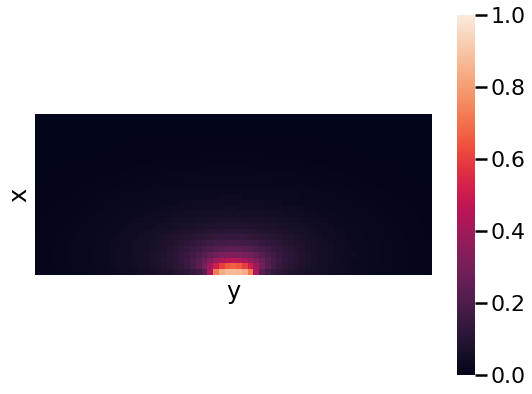

In [288]:
from mplsoccer import Pitch, VerticalPitch
pitch = Pitch(pitch_type='custom',half=True, goal_type='box', line_color='black', pitch_color='white', linewidth=2,pitch_length=105, pitch_width=68, constrained_layout=True)

pitch.draw(figsize=(8,6))
sns.heatmap(heatmap,vmin=0, vmax=1)


In [241]:
x=np.arange(50,106,1)

In [242]:
len(x)

56